<div style="text-align: right"> 
<a href = "https://nbviewer.jupyter.org/github/siddharthchaini/Improving-Feature-Extraction-RESSPECT/blob/main/1.%20light%20curve%20fitting.ipynb"> 
    View online on<br>
    <img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg"
         alt="nbviewer link" style="height: 30px;"/> 
</a>
</div>

# 1. Light-Curve Fitting Approaches for RESSPECT
<a href = http://cosmostatistics-initiative.org/resspect/>
<img src="https://cosmostatistics-initiative.org/wp-content/uploads/2019/04/coin_desc_3.png" alt="Logo" style="width: 250px;"/>
</a>

**Authors**: Siddharth Chaini, Johann Cohen-Tanugi

This is the first Jupyter notebook (of a total of 2) describing the different feature extraction methods explored by Siddharth and Johann in June & July, 2021.

For RESSPECT, a light curve is fit to a function and then the fit parameters are then used in the RESSPECT pipeline as features for training. You can read more about this here: https://arxiv.org/pdf/2010.05941.pdf

In this notebook, we will explore this model fitting based approach in detail, look at different models for fitting the curve and discuss their shortcomings.

In [1]:
import datetime
print('Last Updated On:', datetime.datetime.now().strftime("%d %B, %Y"))

Last Updated On: 16 July, 2021


In [2]:
# Some prerequisites

import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
from scipy.optimize import least_squares, curve_fit
from matplotlib import pylab as plt
import pandas as pd
import glob
import time
from tqdm.notebook import tqdm
import os

import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

import seaborn as sns
sns.set()

def fit1object(filename, fit_scipy, featurename):
    '''
    A function to fit all 6 passbands' lightcurves for a given object.
    '''
    d = pd.read_csv(filename)
    feature_dict = {}
    for filt in "ugrizY":
        temp_dict = {}
        band = d['band']==filt 
        t = np.array(d[band]['mjd'])
        t = t-t[0]
        f = np.array(d[band]['flux'])
        fe = np.array(d[band]['fluxerr'])

        try:
            params_list = list(fit_scipy(t, f, fe))
        except Exception as e:
            params_list = [np.nan for x in featurename]
        for num, feat in enumerate(featurename):
            temp_dict[feat] = params_list[num]
        feature_dict[filt] = temp_dict
    return feature_dict

def plot_fitlc(filename, feature_dict, fitfunction):
    '''
    A function to plot the light curve fits and the original data for all 6 passbands' for a given object.
    '''
    d = pd.read_csv(filename)
    obid = int(filename.split("/")[-1].split("_")[0])
    obclass = filename.split("_")[-1].replace(".csv","")
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
    count=0
    for filt in "ugrizY":
        band = d['band']==filt 
        t = np.array(d[band]['mjd'])
        t = t-t[0]
        f = np.array(d[band]['flux'])
        fe = np.array(d[band]['fluxerr'])
        params = feature_dict[filt].values()
        x = np.arange(t.min(), t.max(),0.001)
        i = int(count/3)
        j = int(count % 3)
        axs[i,j].errorbar(t, f, fe, fmt='.')
        axs[i,j].plot(x, fitfunction(x, *params))
        axs[i,j].set_title(f"Filter {filt}")
        axs[i,j].set_xlabel("Days")
        axs[i,j].set_ylabel("Flux")
        count+=1
    plt.suptitle(f"Objid: {obid} ({obclass}) - {str(fitfunction).split(' ')[1]}")
    return plt

def plot_example(fit_scipy, fitfn, features):
    feature_dict = fit1object("sample_data/130779836_uLens.csv",fit_scipy,features)
    return plot_fitlc("sample_data/130779836_uLens.csv",feature_dict,fitfn)

### 1. Bazin - Old

RESSPECT originally started by using the parameterisation used in [Bazin et. al. (2009)](https://arxiv.org/pdf/0904.1066.pdf) for fitting the light curves ([CODE](https://github.com/COINtoolbox/RESSPECT/blob/9950ad424314ec9391c151d9d589cc4bcc1a34f0/resspect/bazin.py#L26)). 

The implemented version is:

$$ F(t) = \dfrac{e^{\frac{-(t-t_0)}{t_\text{fall}}}}{1+e^{\frac{t-t_0}{t_\text{rise}}}} $$

However, there are a couple of bugs the implemented version as of May 2021. For example, a typo from the [original paper](https://arxiv.org/pdf/0904.1066.pdf) has been carried over where the numerator has the negatively signed $-(t-t_0)$ but the denominator has $(t-t_0)$

The Bazin fit also fails for some PLAsTiCC objects unexpectedly. Let's look at an example: object_id: 130779836, which is an example of a µ-lens from a single lens.

In [3]:
bazinfeatures = ["a", "b", "t0", "tfall", "trise"]

def oldbazin(time, a, b, t0, tfall, trise):
    with np.errstate(over='ignore', invalid='ignore'):
        X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
        return a * X + b
    
def errfunc_oldbazin(params, time, flux, fluxerr):
    return abs(flux - oldbazin(time, *params))

def fit_scipy_oldbazin(time, flux, fluxerr):
    flux = np.asarray(flux)
    t0 = time[flux.argmax()] - time[0]
    guess = [0, 0, t0, 40, -5]

    result = least_squares(errfunc_oldbazin, guess, args=(time, flux, fluxerr), method='lm')

    return result.x

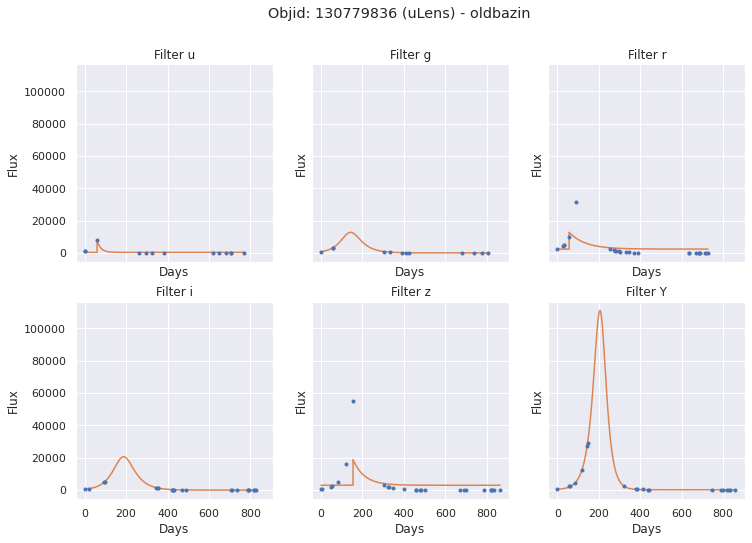

In [4]:
plot_example(fit_scipy_oldbazin,oldbazin,bazinfeatures).show()

It's clearly not fitting well for filter u,r and z above.

### 2. Bazin - New

After examining further, we realise this is mainly happening because of some bound errors, namely because the ratio of `tfall/trise` is supposed to be `>1`, as mentioned in Section 3, [Dai et. al. (2017)](https://arxiv.org/pdf/1701.05689.pdf).

We can further optimise the code as well.

1.  Bazin is modified to take the ratio `r=tfall/trise` instead of `trise`. This allows us to enforce the condition `r>1` on the fit.
2.  Flux_err is used as a parameter to errfunc: `abs(flux - bazin(time, *params)) / fluxerr`
3.  Bounds can be added to `fit_scipy()` and a better original guess was chosen to again enforce the condition `r>1`.

Thus the function has been changed to,

$$ F(t) = \dfrac{e^{\frac{-(t-t_0)}{t_\text{fall}}}}{1+e^{\frac{-(t-t_0)}{t_\text{rise}}}} $$
or, alternatively,
$$ F(t) = \dfrac{e^{\frac{-(t-t_0)}{t_\text{fall}}}}{1+e^{\frac{-(t-t_0)}{t_\text{fall}}r}} $$
where $r=\dfrac{t_\text{fall}}{t_\text{rise}}$.

Let's code up the above changes.

In [5]:
bazinfeatures = ["a", "b", "t0", "tfall", "trise"]

def bazin(time, a, b, t0, tfall, trise):
    with np.errstate(over='ignore', invalid='ignore'):
        X = np.exp(-(time - t0) / tfall) / (1 + np.exp(-(time - t0) / trise))
        return a * X + b

def bazinr(time, a, b, t0, tfall, r):
    trise = tfall/r
    return bazin(time, a, b, t0, tfall, trise)
    
def errfunc_bazin(params, time, flux, fluxerr):
    return abs(flux - bazinr(time, *params)) / fluxerr

def fit_scipy_bazin(time, flux, fluxerr):
    flux = np.asarray(flux)
    imax = flux.argmax()
    flux_max = flux[imax]
    
    # Parameter guess
    a_guess = 2*flux_max
    b_guess = 0
    t0_guess = time[imax]
    
    tfall_guess = time[imax-2:imax+2].std()/2
    if np.isnan(tfall_guess):
        tfall_guess = time[imax-1:imax+1].std()/2
        if np.isnan(tfall_guess):
            tfall_guess=50
    if tfall_guess<1:
        tfall_guess=50

    r_guess = 2

    guess = [a_guess,b_guess,t0_guess,tfall_guess,r_guess]

    # Parameter bounds
    a_bounds = [1.e-3, np.inf]
    b_bounds = [-np.inf, np.inf]
    t0_bounds = [-0.5*time.max(), 1.5*time.max()]
    tfall_bounds = [1.e-3, np.inf]
    r_bounds = [1, np.inf]
    
    bounds = [[a_bounds[0], b_bounds[0], t0_bounds[0], tfall_bounds[0], r_bounds[0]],
              [a_bounds[1], b_bounds[1], t0_bounds[1], tfall_bounds[1], r_bounds[1]]]
    
    result = least_squares(errfunc_bazin, guess, args=(time, flux, fluxerr), method='trf', loss='linear',bounds=bounds)
    
    a_fit,b_fit,t0_fit,tfall_fit,r_fit = result.x
    trise_fit = tfall_fit/r_fit
    final_result = np.array([a_fit,b_fit,t0_fit,tfall_fit,trise_fit])
    
    return final_result

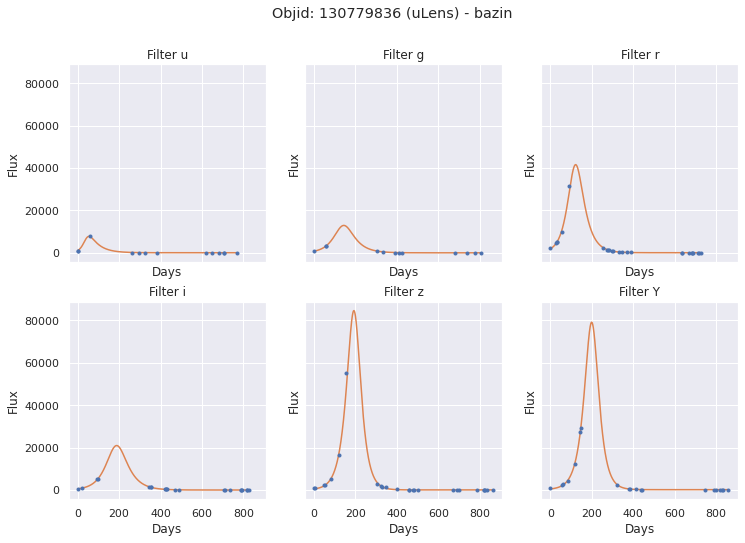

In [6]:
plot_example(fit_scipy_bazin,bazin,bazinfeatures).show()

And voila! We have a better fit.

There is a clear improvement in the fit for the "u", "r" and "z" bands. This change has been incorporated into Pull Request #49 for RESSPECT - https://github.com/COINtoolbox/RESSPECT/pull/49

Let us look at more functions for similar curve fitting parameterisations.

### 3. FRED

This parameterisation is based on the equation 3 from [Peng et. al. (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/698/1/417):
$$
F(t)=F_{m}\left(\frac{t+t_{0}}{t_{m}+t_{0}}\right)^{r}\left[\frac{d}{d+r}+\frac{r}{d+r}\left(\frac{t+t_{0}}{t_{m}+t_{0}}\right)^{(r+1)}\right]^{-\frac{r + d}{r+1}}
$$

In [7]:
fredfeatures = ["tm", "r", "d", "Fm", "b"]

def fred(time, tm, r, d, Fm, b):
    t0 = 0 # No trigger time in our case and timestamps are arbitrary, so t0 = 0
    x = (time+t0)/(tm+t0)
    val = Fm * (x)**r * ((d)/(d+r) + (r)/(d+r) * (x)**(r+1) )**(-(r+d)/(r+1)) + b
    return val

def errfunc_fred(params, time, flux, fluxerr):
    return abs(flux - fred(time, *params))/ fluxerr


def fit_scipy_fred(time, flux, fluxerr):
    flux = np.asarray(flux)
    imax = flux.argmax()
    flux_max = flux[imax]
    
    tm_bounds = [-0.5*time.max(), 1.5*time.max()]
    r_bounds = [1.e-3,np.inf]
    d_bounds = [1.e-3,np.inf]
    Fm_bounds = [-np.inf,np.inf]
    b_bounds = [-np.inf,np.inf]
    
    # Parameter guess
    tm_guess = time[imax]
    r_guess = 30
    d_guess = 30
    Fm_guess = flux_max
    b_guess = time[0]
    
    guess = [tm_guess, r_guess, d_guess, Fm_guess, b_guess]

    result = least_squares(errfunc_fred, guess, args=(time, flux, fluxerr), method='trf', loss='linear',\
                                  bounds=([tm_bounds[0], r_bounds[0], d_bounds[0], Fm_bounds[0], b_bounds[0]],
                                          [tm_bounds[1], r_bounds[1], d_bounds[1], Fm_bounds[1], b_bounds[1]])
                          )
    
    return result.x

<ipython-input-7-df6b65c3b3bb>:6: RuntimeWarning: overflow encountered in power
  val = Fm * (x)**r * ((d)/(d+r) + (r)/(d+r) * (x)**(r+1) )**(-(r+d)/(r+1)) + b
<ipython-input-7-df6b65c3b3bb>:6: RuntimeWarning: invalid value encountered in multiply
  val = Fm * (x)**r * ((d)/(d+r) + (r)/(d+r) * (x)**(r+1) )**(-(r+d)/(r+1)) + b
<ipython-input-7-df6b65c3b3bb>:6: RuntimeWarning: invalid value encountered in power
  val = Fm * (x)**r * ((d)/(d+r) + (r)/(d+r) * (x)**(r+1) )**(-(r+d)/(r+1)) + b


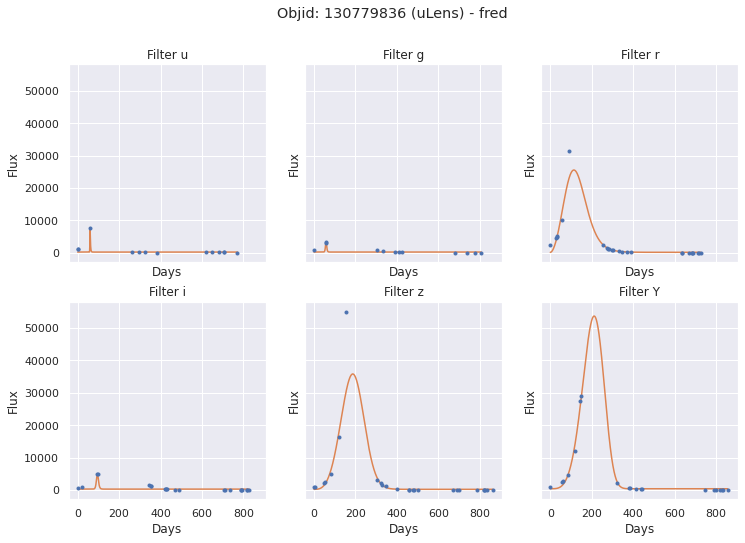

In [8]:
plot_example(fit_scipy_fred,fred,fredfeatures).show()

### 4. Karpenka

This parameterisation is based on the equation 1 from [Karpenka et. al. (2013)](https://academic.oup.com/mnras/article/429/2/1278/1038192), where an offset parameter c has been added:

$$
f(t)=A\left[1+B\left(t-t_{1}\right)^{2}\right] \frac{e^{-\left(t-t_{0}\right) / t_{\text {fall }}}}{1+e^{-\left(t-t_{0}\right) / t_{\text {rise }}}} + c
$$

In [9]:
karpenkafeatures = ["a", "b", "t0", "tfall", "trise", "t1", "c"]

def karpenka(time, a, b, t0, tfall, trise, t1, c):
    val = a*(1+b*(time-t1)**2)* (np.exp(-(time-t0)/tfall))/(1+np.exp(-(time-t0)/trise))
    return val + c

def karpenkar(time, a, b, t0, tfall, r, t1, c):
    trise = tfall/r
    return karpenka(time, a, b, t0, tfall, trise, t1, c)

def errfunc_karpenka(params, time, flux, fluxerr):
    return abs(flux - karpenkar(time, *params)) / fluxerr

def fit_scipy_karpenka(time, flux, fluxerr):
    flux = np.asarray(flux)
    imax = flux.argmax()
    flux_max = flux[imax]
    
    # Parameter guess
    a_guess = 2*flux_max
    b_guess = 0
    t0_guess = time[imax]
    t1_guess = time[imax]
    c_guess = 0
    
    tfall_guess = time[imax-2:imax+2].std()/2
    if np.isnan(tfall_guess):
        tfall_guess = time[imax-1:imax+1].std()/2
        if np.isnan(tfall_guess):
            tfall_guess=50
    if tfall_guess<1:
        tfall_guess=50

    r_guess = 2

    guess = [a_guess,b_guess,t0_guess,tfall_guess,r_guess,t1_guess,c_guess]

    # Parameter bounds
    a_bounds = [1.e-3, np.inf]
    b_bounds = [-np.inf, np.inf]
    t0_bounds = [-0.5*time.max(), 1.5*time.max()]
    t1_bounds = [-0.5*time.max(), 1.5*time.max()]
    tfall_bounds = [1.e-3, np.inf]
    r_bounds = [1, np.inf]
    c_bounds = [-np.inf, np.inf]
    
    bounds = [[a_bounds[0], b_bounds[0], t0_bounds[0], tfall_bounds[0], r_bounds[0], t1_bounds[0], c_bounds[0]],
              [a_bounds[1], b_bounds[1], t0_bounds[1], tfall_bounds[1], r_bounds[1], t1_bounds[1], c_bounds[1]]]
    
    result = least_squares(errfunc_karpenka, guess, args=(time, flux, fluxerr), method='trf', loss='linear',bounds=bounds)
    
    a_fit,b_fit,t0_fit,tfall_fit,r_fit,t1_fit,c_fit = result.x
    trise_fit = tfall_fit/r_fit
    final_result = np.array([a_fit,b_fit,t0_fit,tfall_fit,trise_fit,t1_fit,c_fit])
    
    return final_result

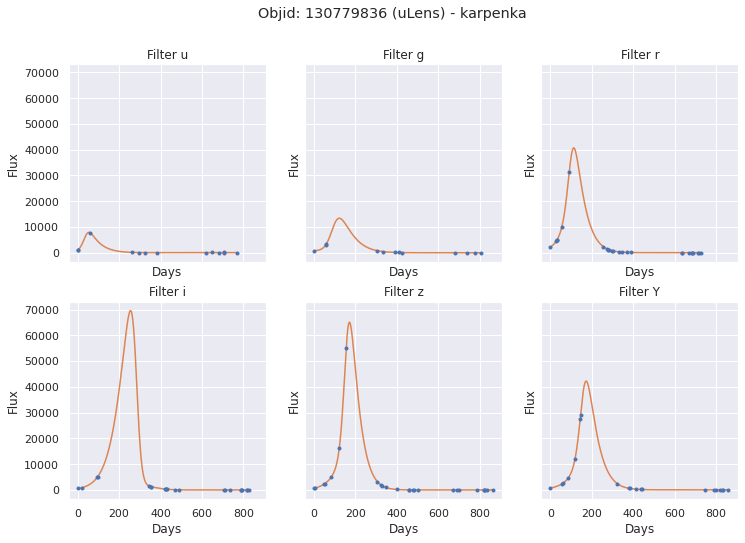

In [10]:
plot_example(fit_scipy_karpenka,karpenka,karpenkafeatures).show()

### 5. Villar

This parameterisation is based on the equation 1 from [Villar et. al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4357/ab418c):

$$
F= \begin{cases}\frac{A+\beta\left(t-t_{0}\right)}{1+e^{-\left(t-t_{0}\right) / t_\text{rise}}} & t<t_{1} \\ \frac{\left(A+\beta\left(t_{1}-t_{0}\right)\right) e^{-\left(t-t_{1}\right) / t_{\text {fall }}}}{1+e^{-\left(t_{0}-t_{0}\right) / t_{\text {rise }}}} & t \geq t_{1}\end{cases}
$$

In [11]:
villarfeatures = ["a", "beta", "t0", "gamma", "t_fall", "t_rise"]

def villarupper(time,a,beta,t0,t1,tfall,trise):
    val = (a + beta*(time-t0))/(1+np.exp(-(time-t0)/trise))
    return val

def villarlower(time,a,beta,t0,t1,tfall,trise):
    val = ((a+beta*(t1-t0))*np.exp(-(time-t1)/tfall))/(1+np.exp(-(time-t0)/trise))
    return val

def villar(time,a,beta,t0,gamma,tfall,trise):
    t1 = t0 + gamma
    val = np.piecewise(time, [time < t1, time >= t1], [lambda time: villarupper(time,a,beta,t0,t1,tfall,trise), lambda time: villarlower(time,a,beta,t0,t1,tfall,trise)])
    return val

def errfunc_villar(params, time, flux, fluxerr):
    return abs(flux - villar(time, *params))/ fluxerr

def fit_scipy_villar(time, flux, fluxerr):
    flux = np.asarray(flux)
    imax = flux.argmax()
    t0 = time[imax]
    max_flux = flux[imax]
    if max_flux>0:
        a_bounds = [max_flux / 3.0, max_flux * 3.0]
    else:
        a_bounds = [-np.inf, np.inf]
    beta_bounds = [0.0, 1.0]
    t0_bounds = [-0.5*time.max(), 1.5*time.max()]
    gamma_bounds = [1.0, 100.0]
    tfall_bounds = [1.0, 100.0]
    trise_bounds = [1.0, 100.0]

    
    a_guess = np.clip(1.5 * max_flux, a_bounds[0], a_bounds[1])
    beta_guess = 0
    t0_guess = np.clip(time[imax] * 2.0 / 3.0, t0_bounds[0], t0_bounds[1])
    gamma_guess = np.clip(time[imax], gamma_bounds[0], gamma_bounds[1])
    tfall_guess = 50
    trise_guess = 45
    
    guess = [a_guess, beta_guess, t0_guess, gamma_guess, tfall_guess, trise_guess]
    
    result = least_squares(errfunc_villar, guess, args=(time, flux, fluxerr), method='trf', loss='linear',\
                                  bounds=([a_bounds[0], beta_bounds[0], t0_bounds[0], gamma_bounds[0], tfall_bounds[0], trise_bounds[0]],
                                         [a_bounds[1], beta_bounds[1], t0_bounds[1], gamma_bounds[1], tfall_bounds[1], trise_bounds[1]])
                          )
    return result.x


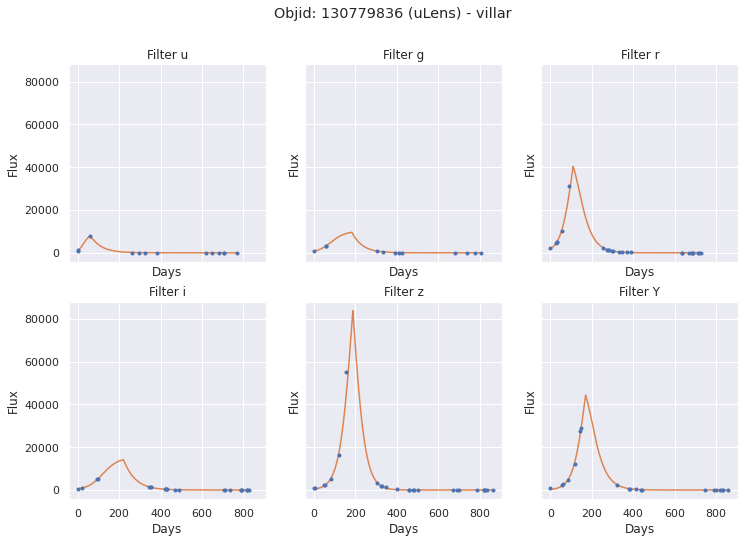

In [12]:
plot_example(fit_scipy_villar,villar,villarfeatures).show()

### 6. ALERCE v1

This parameterisation is based on the equation A4 from [Sanchez-Sael et. al. (2021)](https://iopscience.iop.org/article/10.3847/1538-4357/ab418c).

$$
F=\left\{\begin{array}{c}
\frac{A\left(1-\beta^{\prime} \frac{t-t_{0}}{t_{1}-t_{0}}\right)}{1+\exp \left(-\frac{t-t_{0}}{\tau_{\text {rise }}}\right)} \quad \text { if } t<t_{1} \\
\frac{A\left(1-\beta^{\prime}\right) \exp \left(-\frac{t-t_{1}}{\tau_{\text {fall }}}\right)}{1+\exp \left(-\frac{t-t_{0}}{\tau_{\text {rise }}}\right)} \text { if } t \geq t_{1}
\end{array}\right.
$$

This is a small modification of the one used by [Villar et. al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4357/ab418c).

In [13]:
alercev1features = ["a", "beta", "t0", "gamma", "t_fall", "t_rise"]

def upperfn(time,a,beta,t0,t1,tfall,trise):
    val = (a*(1 - beta*(time-t0)/(t1-t0)))/(1+np.exp(-(time-t0)/trise))
    return val
def lowerfn(time,a,beta,t0,t1,tfall,trise):
    val = (a*(1-beta)*np.exp(-(time-t1)/tfall))/(1+np.exp(-(time-t0)/trise))
    return val
def alercev1(time,a,beta,t0,gamma,tfall,trise):
    t1 = t0 + gamma
    val = np.piecewise(time, [time < t1, time >= t1], [lambda time: upperfn(time,a,beta,t0,t1,tfall,trise), lambda time: lowerfn(time,a,beta,t0,t1,tfall,trise)])
    return val

def errfunc_alercev1(params, time, flux, fluxerr):
    return abs(flux - alercev1(time, *params))/ fluxerr

def fit_scipy_alercev1(time, flux, fluxerr):
    flux = np.asarray(flux)
    imax = flux.argmax()
    t0 = time[imax]
    max_flux = flux[imax]
    if max_flux>0:
        a_bounds = [max_flux / 3.0, max_flux * 3.0]
    else:
        a_bounds = [-np.inf, np.inf]
    beta_bounds = [0.0, 1.0]
    t0_bounds = [-0.5*time.max(), 1.5*time.max()]
    gamma_bounds = [1.0, 100.0]
    tfall_bounds = [1.0, 100.0]
    trise_bounds = [1.0, 100.0]

    
    a_guess = np.clip(1.5 * max_flux, a_bounds[0], a_bounds[1])
    beta_guess = 0
    t0_guess = np.clip(time[imax] * 2.0 / 3.0, t0_bounds[0], t0_bounds[1])
    gamma_guess = np.clip(time[imax], gamma_bounds[0], gamma_bounds[1])
    tfall_guess = 50
    trise_guess = 45
    
    guess = [a_guess, beta_guess, t0_guess, gamma_guess, tfall_guess, trise_guess]
    
    result = least_squares(errfunc_alercev1, guess, args=(time, flux, fluxerr), method='trf', loss='linear',\
                                  bounds=([a_bounds[0], beta_bounds[0], t0_bounds[0], gamma_bounds[0], tfall_bounds[0], trise_bounds[0]],
                                         [a_bounds[1], beta_bounds[1], t0_bounds[1], gamma_bounds[1], tfall_bounds[1], trise_bounds[1]])
                          )
    return result.x


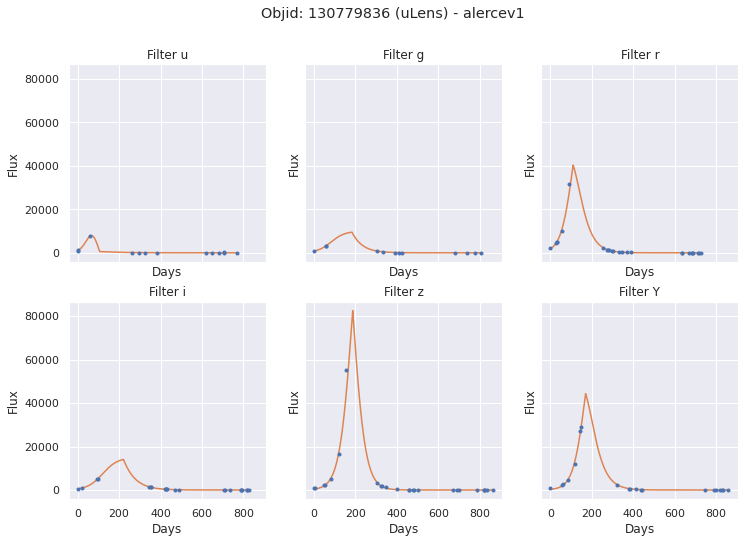

In [14]:
plot_example(fit_scipy_alercev1,alercev1,alercev1features).show()

### 7. Sánchez-Sáez (ALERCE v2)

This parameterisation is based on the equation A5 from [Sanchez-Sael et. al. (2021)](https://iopscience.iop.org/article/10.3847/1538-4357/ab418c).

$$
F=\frac{A\left(1-\beta^{\prime} \frac{t-t_{0}}{t_{1}-t_{0}}\right)}{1+\exp \left(-\frac{t-t_{0}}{\tau_{\text {rise }}}\right)} \cdot\left[1-\sigma\left(\frac{t-t_{1}}{3}\right)\right]+\frac{A\left(1-\beta^{\prime}\right) \exp \left(-\frac{t-t_{1}}{\tau_{\text {fall }}}\right)}{1+\exp \left(-\frac{t-t_{0}}{\tau_{\text {rise }}}\right)} \cdot\left[\sigma\left(\frac{t-t_{1}}{3}\right)\right]
$$

In [15]:
alercev2features = ["A", "t0", "gamma", "beta", "t_rise", "t_fall"]

def alercev2(times, A, t0, gamma, beta, t_rise, t_fall):
    sigmoid_factor = 1.0 / 3.0
    t1 = t0 + gamma

    sigmoid = 1.0 / (1.0 + np.exp(-sigmoid_factor * (times - t1)))
    den = 1 + np.exp(-(times - t0) / t_rise)
    flux = ((1 - beta) * np.exp(-(times - t1) / t_fall)
            * sigmoid
            + (1. - beta * (times - t0) / gamma)
            * (1 - sigmoid)) * A / den
    return flux

def fit_scipy_alercev2(times, fluxpsf, obs_errors):
    '''
    Adapted from:
    https://github.com/alercebroker/lc_classifier/blob/main/lc_classifier/features/extractors/sn_parametric_model_computer.py#L113
    '''
    # Parameter bounds
    argmax_fluxpsf = np.argmax(fluxpsf)
    max_fluxpsf = fluxpsf[argmax_fluxpsf]
    A_bounds = [max_fluxpsf / 5, max_fluxpsf * 5]
    t0_bounds = [-0.5*times.max(), times.max()]
    gamma_bounds = [1.0, 50]  # (1,50/100)
    beta_bounds = [0.0, 1.0]
    trise_bounds = [1.0, 100.0]
    tfall_bounds = [1.0, 100.0]
    
    
    # Parameter guess
    A_guess = np.clip(1.5 * max_fluxpsf, A_bounds[0], A_bounds[1])
    t0_guess = np.clip(times[argmax_fluxpsf] * 2.0 / 3.0, t0_bounds[0], t0_bounds[1])
    gamma_guess = np.clip(times[argmax_fluxpsf], gamma_bounds[0], gamma_bounds[1])
#     gamma_guess = 50
    beta_guess = 0
    trise_guess = np.clip(times[argmax_fluxpsf] / 2.0, trise_bounds[0], trise_bounds[1])
#     print(f"trise_gess = np.clip({times[argmax_fluxpsf] / 2.0},{trise_bounds[0]},{trise_bounds[1]})")
#     trise_guess = 45
    tfall_guess = 40
        
    p0 = [A_guess, t0_guess, gamma_guess,
          beta_guess, trise_guess, tfall_guess]
    # get parameters
    try:
        pout, pcov = curve_fit(
            f=alercev2,
            xdata=times,
            ydata=fluxpsf,
            p0=p0,
            sigma=5+obs_errors,
            bounds=[[A_bounds[0], t0_bounds[0], gamma_bounds[0], beta_bounds[0], trise_bounds[0], tfall_bounds[0]],
                    [A_bounds[1], t0_bounds[1], gamma_bounds[1], beta_bounds[1], trise_bounds[1], tfall_bounds[1]]],
            ftol=1e-8,
            # verbose=2
        )
    except (ValueError, RuntimeError, OptimizeWarning):
        try:
            # print('First fit of SPM failed. Attempting second fit.')
            pout, pcov = curve_fit(
                f=alercev2,
                xdata=times,
                ydata=fluxpsf,
                p0=p0,
                sigma=5+obs_errors,
                bounds=[[A_bounds[0], t0_bounds[0], gamma_bounds[0], beta_bounds[0], trise_bounds[0], tfall_bounds[0]],
                        [A_bounds[1], t0_bounds[1], gamma_bounds[1], beta_bounds[1], trise_bounds[1], tfall_bounds[1]]],
                ftol=0.1,
                # verbose=2
            )
        except (ValueError, RuntimeError, OptimizeWarning):
            # print('Two fits of SPM failed. Returning NaN.')
            pout = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])    
    return pout


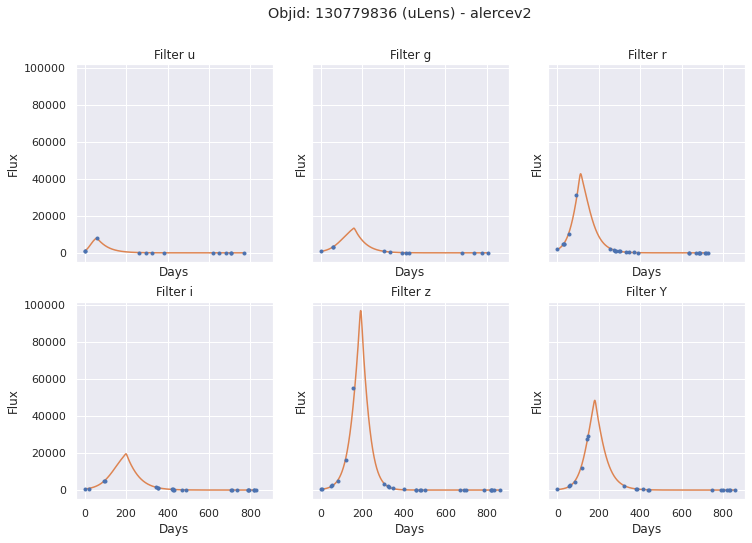

In [16]:
plot_example(fit_scipy_alercev2,alercev2,alercev2features).show()

## Summary

Table 1: A comparison of the different parameterisations for full light curve fitting.

|    | Parameterisation Used      |   Average Time per Object for all 6 passbands (s) |   Average F1 Score for RFC (n=150) |   Total objects (of 480) where fit failed (for ≥ 1 passband) |
|---:|:---------------------------|--------------------------------------------------:|-----------------------------------:|-------------------------------------------------------------:|
|  0 | Bazin - old implementation |                                        0.00814443 |                           0.567551 |                                                            0 |
|  1 | Bazin - new implementation |                                        0.0370185  |                           0.61107  |                                                           11 |
|  2 | FRED                       |                                        0.0515021  |                           0.453149 |                                                           54 |
|  3 | Karpenka                   |                                        0.140439   |                           0.423564 |                                                           12 |
|  4 | Villar                     |                                        0.0427893  |                           0.425545 |                                                            0 |
|  5 | Alercev1                   |                                        0.0547328  |                           0.490861 |                                                            0 |
|  6 | Alercev2                   |                                        0.0950013  |                           0.481691 |                                                           10 |


---


Table 1 is based on the results of a Random Forest Classifier (10-fold CV, n=150), which I trained on the following 8 extragalactic DDF classes, 60 samples  each, from PLAsTiCC:
- SNIa (WD detonation Type Ia SN)
- SNIa-91bg (Peculiar type Ia: 91bg)
- SNIax (Peculiar SNIax)
- SNII (Core Collapse Type II SN)
- SNIbc (Core Collapse Type Ibc SN)
- SLSN-I (Super-Lum. SN - magnetar)
- TDE (Tidal Disruption Event)
- AGN (Active Galactic Nuclei)

I chose 60 samples as that was the maximum number of TDE samples available in some given set of PLAsTiCC, and I wanted to keep it a balanced class problem. All parameterisations were calculated by fitting the full light curve. The comparative score is the F1 Score for the above RFC.

The time taken here is not representative of the time it would take for RESSPECT, for example, because I was working on my personal laptop. Further, as the dataset was small, the comparative (F1) score is not in any means representative of how well it will work for RESSPECT. But since everything was identical, it does provide a way to compare the which one works better.

The code for generating the above table can be found on this GitHub repository: https://github.com/siddharthchaini/comparing-parameterisations

## Limitations of all curve fitting approaches
1. Slow - As it involves fitting 6 functions (so 30-40 free parameters) for each object.
2. Greedy - Each passband is treated and fit independently.
3. Data intensive - Each fit needs 5 points per light-curve per passband. This is not ideal for early light curve classification, which is important for RESSPECT.
4. Not very robust - Designed for SNIa & SNII 

Because of the above reasons, we are interested in other modern deep-learning based approaches, like GP-VAE.

You can find more about GP-VAE in the next notebook here: #TODO